Wordvectors & Word2Vec
====
Kant-en-klaar Word2Vec model m.b.v. Gensim
----
In dit voorbeeld maken we een Word2Vec model met behulp van de [Gensim] module voor Python. 

Het Word2Vec model van [Mikolov et al] beschrijft effectieve methodes voor het leren van relaties tussen vectors van woorden. Het model blijkt erg goed voor het vastleggen van vector representaties met een groot aantal precieze syntactische en semantische woord relaties, die daarnaast ook nog van hoge kwaliteit zijn. 

[Gensim]: https://radimrehurek.com/gensim/
[Mikolov et al]: http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf

Credits naar [Yuri] voor de code.
[Yuri]:https://github.com/YuriyGuts/

In [1]:
# Handig om python 2/3 errors en frustratie te voorkomen
from __future__ import absolute_import, division, print_function

In [2]:
# Importeren van de hulpmiddelen/tools
import codecs
import glob
import os
import pprint
import re

In [3]:
# Importeren van de Language Processing modules

import nltk # NLTK - Natural Language Toolkit

# Gensim's Word2Vec implementatie.
import gensim.models.word2vec as w2v

# Vooral handig als je op een HPC traint met vele processoren (bijv 1 cpu per thread).
import multiprocessing


In [4]:
# Niet vergeten je acties te loggen en tonen
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
# Importeren van modules voor data manipulatie en visualisatie
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
# In dit voorbeeld gebruiken we de werken van William Shakespeare (credits Project Gutenberg!)
boeken = glob.glob("textdata/*.txt")
print(sorted(boeken))

['textdata/de_getemde_feeks.txt', 'textdata/de_koopman_van_venetie.txt', 'textdata/een_midzomernachtdroom.txt', 'textdata/rome_en_julia.txt', 'textdata/twee_edellieden_van_verona.txt', 'textdata/veel_gemin_geen_gewin.txt']


In [7]:
raw_text = ""
for boek in boeken:
    print("Inlezen van: '{0}'...".format(boek))
    with codecs.open(boek, "r", "utf-8") as boek_bestand:
        raw_text += boek_bestand.read()
    print("De tekstverzameling is nu {0} letters lang".format(len(raw_text)))
    print()

Inlezen van: 'textdata/de_getemde_feeks.txt'...
De tekstverzameling is nu 136435 letters lang

Inlezen van: 'textdata/de_koopman_van_venetie.txt'...
De tekstverzameling is nu 270260 letters lang

Inlezen van: 'textdata/een_midzomernachtdroom.txt'...
De tekstverzameling is nu 374788 letters lang

Inlezen van: 'textdata/rome_en_julia.txt'...
De tekstverzameling is nu 530993 letters lang

Inlezen van: 'textdata/twee_edellieden_van_verona.txt'...
De tekstverzameling is nu 645613 letters lang

Inlezen van: 'textdata/veel_gemin_geen_gewin.txt'...
De tekstverzameling is nu 788109 letters lang



In [8]:
# Nu moet de lange string met al Shakespeare's werken in tokens gehakt worden.
DutchTokenizer = nltk.data.load('tokenizers/punkt/dutch.pickle')

In [9]:
raw_zinnen = DutchTokenizer.tokenize(raw_text)
print("In raw_zinnen vormen de werken een lange string:\n",raw_zinnen[5])

In raw_zinnen vormen de werken een lange string:
 Battista, een rijk edelman van Padua.


In [10]:
# Deze functie zet een zin (string) om naar list met woorden (tokens).
def zin_naar_woordlijst(raw):
    schoon = re.sub("[^a-zA-Z]"," ", raw)
    woorden = schoon.split()
    return woorden

In [11]:
# De functie gebruiken we om de zinnen te tokenizen
zinnen = []
for zin in raw_zinnen:
    if len(zin) > 0:
        zinnen.append(zin_naar_woordlijst(zin))

In [12]:
# Check het verschil:
print("Raw zinnen (string):\n", raw_zinnen[5],"\n")
print("Zinnen getokeniseerd (list):\n", zin_naar_woordlijst(raw_zinnen[5]))

Raw zinnen (string):
 Battista, een rijk edelman van Padua. 

Zinnen getokeniseerd (list):
 ['Battista', 'een', 'rijk', 'edelman', 'van', 'Padua']


In [13]:
aantal_tokens = sum([len(zin) for zin in zinnen])
print("Het totaal aantal tokens:\n",aantal_tokens)

Het totaal aantal tokens:
 133739


Word2Vec model parameters
====
In dit model wordt elke token (woord) omgezet naar een vector. Voor het model dien je aan zelf de parameters aan te geven. Afhankelijk van de data die je gebruikt is het zoeken naar waardes die hier goed bij passen. De volgende parameters definieren we vooraf:
<ul>
<li>seed = seed, hier <i>1</i>, willekeurig nummer vastgelegd zodat de resultaten repliceerbaar zijn</li>
<li>workers = aantal_workers, threads (of processoren die tegelijkertijd het model bouwen). Dit wordt automatisch door de multiprocessing module bepaald.</li>
<li>size = dimensies, hier <i>128</i>, hoe meer dimensionaliteit, hoe groter en complexer het model wordt. </li>
<li>min_count = minimaal_freq, <i>hier 3</i>, de frequentie van een woord in de tekst om in het model meegenomen te worden.</li>
<li>window = context_window, hier <i>7</i>, de context hoeveel woorden links en rechts van het 'huidige' woord de context omvat.</li>
<li>sample = mindersamplen, hier <i>1000 keer</i>, Weeg veel voorkomende woorden minder zwaar in het model mee.</li>

In [14]:
seed = 1
dimensies = 128
minimaal_freq = 3
aantal_workers = multiprocessing.cpu_count()
context_window = 7
mindersamplen = 1e-3

In [15]:
# Instantieer het Word2Vec object
ShakespeareVectorModel = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=aantal_workers,
    size=dimensies,
    min_count=minimaal_freq,
    window=context_window,
    sample=mindersamplen
)


In [16]:
# Bouw de woordenboek/vocab voor het model
ShakespeareVectorModel.build_vocab(zinnen)

2017-07-12 18:22:13,878 : INFO : collecting all words and their counts
2017-07-12 18:22:13,880 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-07-12 18:22:13,934 : INFO : PROGRESS: at sentence #10000, processed 98592 words, keeping 11197 word types
2017-07-12 18:22:13,956 : INFO : collected 13799 word types from a corpus of 133739 raw words and 14195 sentences
2017-07-12 18:22:13,958 : INFO : Loading a fresh vocabulary
2017-07-12 18:22:13,989 : INFO : min_count=3 retains 4220 unique words (30% of original 13799, drops 9579)
2017-07-12 18:22:13,990 : INFO : min_count=3 leaves 122107 word corpus (91% of original 133739, drops 11632)
2017-07-12 18:22:14,013 : INFO : deleting the raw counts dictionary of 13799 items
2017-07-12 18:22:14,016 : INFO : sample=0.001 downsamples 59 most-common words
2017-07-12 18:22:14,017 : INFO : downsampling leaves estimated 96053 word corpus (78.7% of prior 122107)
2017-07-12 18:22:14,019 : INFO : estimated required memory for

In [17]:
print("Word2Vec woordenboek/vocab lengte:", len(ShakespeareVectorModel.wv.vocab))

Word2Vec woordenboek/vocab lengte: 4220


Het Word2Vec Model Trainen
====

In [18]:
# De instantie van het Word2Vec Model traint nu de vector-waardes van elk woord voor de text. 
# Dit kan even duren (afhankelijk van je data).
ShakespeareVectorModel.train(zinnen, total_examples=ShakespeareVectorModel.corpus_count, epochs=ShakespeareVectorModel.iter)

2017-07-12 18:22:16,236 : INFO : training model with 4 workers on 4220 vocabulary and 128 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-07-12 18:22:17,251 : INFO : PROGRESS: at 75.59% examples, 365197 words/s, in_qsize 7, out_qsize 0
2017-07-12 18:22:17,503 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-07-12 18:22:17,539 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-07-12 18:22:17,551 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-07-12 18:22:17,552 : INFO : worker thread finished; awaiting finish of 0 more threads
2017-07-12 18:22:17,554 : INFO : training on 668695 raw words (480095 effective words) took 1.3s, 367860 effective words/s


480095

In [19]:
if not os.path.exists("getrainde_modellen"):
    os.makedirs("getrainde_modellen")
    
# Opslaan dat model!
ShakespeareVectorModel.wv.save(os.path.join("getrainde_modellen", "ShakespeareVectorModel.w2v"))

2017-07-12 18:22:17,572 : INFO : saving KeyedVectors object under getrainde_modellen/ShakespeareVectorModel.w2v, separately None
2017-07-12 18:22:17,575 : INFO : not storing attribute syn0norm
2017-07-12 18:22:17,635 : INFO : saved getrainde_modellen/ShakespeareVectorModel.w2v


Het Word2Vec model visualiseren 
----
Het hiervoor getrainde model bevat 512 dimensies voor elk woord. Dat is moeilijk in beeld te brengen. Toch is het prettig om te zien hoe de data er uitziet. Hiervoor gebruiken we T-SNE, of voluit t-distributed Stochastic Neighbor Embedding [Maaten en Hinton, 2008]. 

De [Scikit-learn module] heeft hiervoor een ingebouwde functie. 

T-SNE: 'TieSnie'
----
Om de data uit het multi-dimensionale model te visualiseren drukken we het als het ware plat naar 2 dimensies met de [T-SNE module]. Vervolgens plotten we elk woord naar het corresponderende x- of y-as in de 2-dimensionale ruimte. 

[Maaten en Hinton, 2008]: http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf
[Scikit-learn module]: http://scikit-learn.org/stable/
[T-SNE module]: http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [20]:
# Initialiseer TSNE
tsne = sklearn.manifold.TSNE(n_components=2, init='pca', random_state=0)

In [21]:
# Maak een matrix met daarin alle vectors uit het model
all_word_vectors_matrix = ShakespeareVectorModel.wv.syn0

In [22]:
# Gebruik T-SNE om de matrix naar 2 dimensies te transformeren. 
# Dit kan even duren (afhankelijk van je data).
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [23]:
# Elk van de woordvectors is een punt met een x- en y-as. Die slaan we op in een Pandas DataFrame.
# De punten worden zo efficient in een database opgeslagen.
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[ShakespeareVectorModel.wv.vocab[word].index])
            for word in ShakespeareVectorModel.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

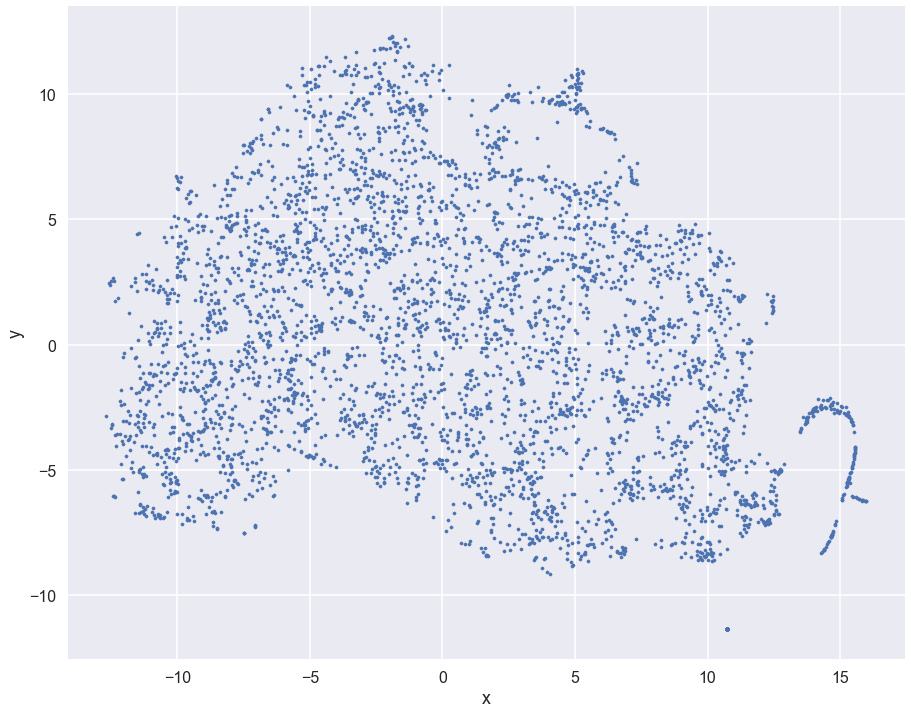

In [24]:
# En hier plotten we alle punten in een scatterplot
sns.set_context("poster")
points.plot.scatter("x", "y", s=10, figsize=(15, 12))

Zoals te zien in de scatterplot zijn de punten verspreid over de gehele matrix. Om de data inzichtelijk te maken kunnen we het woord dat bij een punt hoort toevoegen aan de plot, maar dan zie je door de bomen het bos niet meer. Voor het maken van een scatterplot met de bijbehorende woorden gebruiken we daarom de volgende functie:

In [25]:
def plot_regio(x_grens, y_grens):
    slice = points[
        (x_grens[0] <= points.x) &
        (points.x <= x_grens[1]) & 
        (y_grens[0] <= points.y) &
        (points.y <= y_grens[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

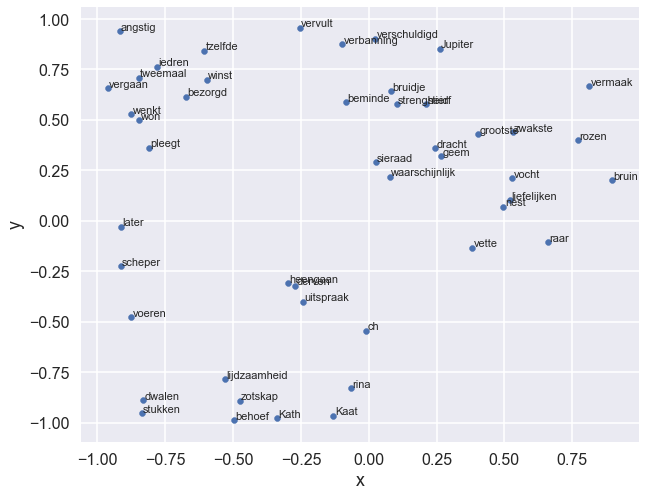

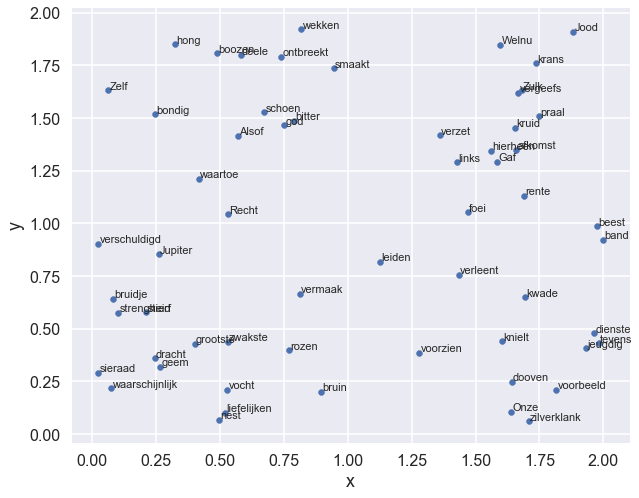

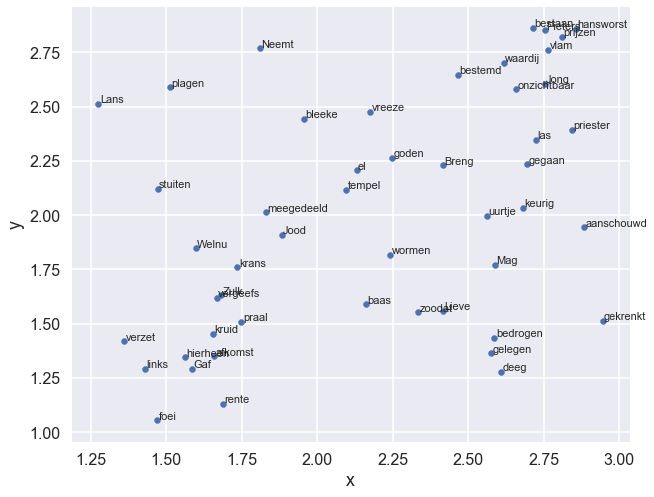

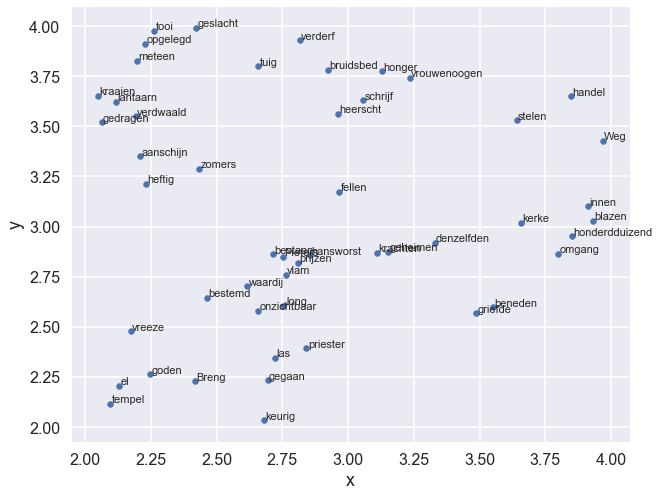

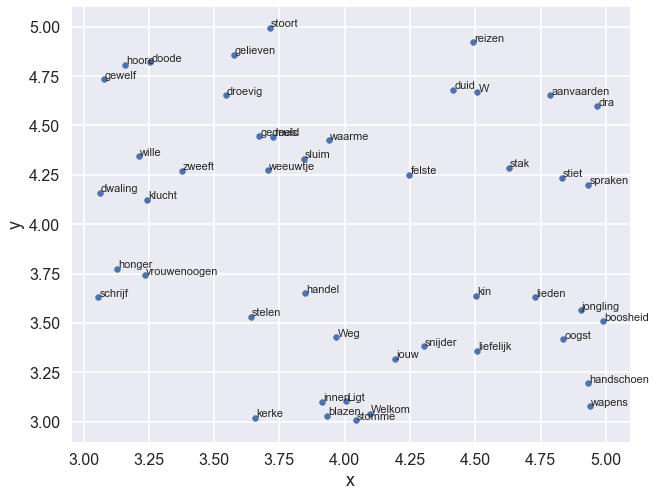

In [26]:
# Nu een kijkje van dichtbij met de woord labels bij de punten. Hiervoor een simpele for loop om 5 plots te maken:
for i in range(5):
    x1 = i-1
    x2 = i+1
    y1 = i-1
    y2 = i+1
    plot_regio(x_grens=(x1,x2),y_grens=(y1,y2))

Wil je weten waar een 'woord' in de matrix te vinden is kan dat als volgt:

In [27]:
# Eerst zoek je in het model de index van het gekozen woord op:
ShakespeareVectorModel.wv.vocab["Romeo"].index

130

In [28]:
#Vervolgens is kun je die index opzoeken in de matrix
all_word_vectors_matrix_2d[130]

array([ 4.32726068,  9.91762901])

Onze geliefde "Romeo", of eigenlijk de woordvector voor de naam "Romeo" is in te vinden op:<br>
X = 4.32726068<br>
Y = 9.91762901<br>
Laten we daar ook eens een kijkje nemen:

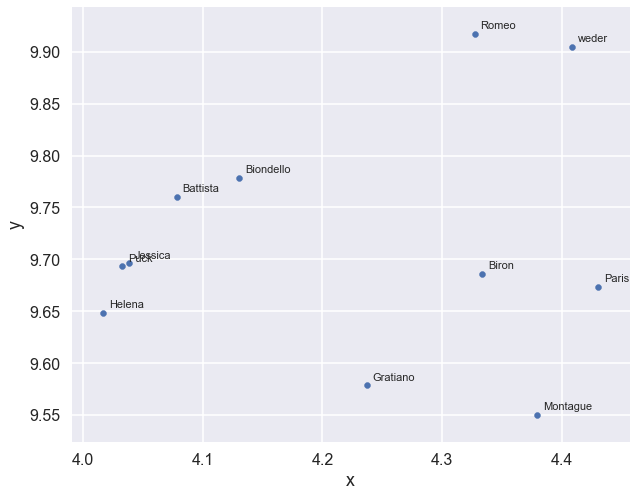

In [29]:
plot_regio(x_grens=(4,4.5),y_grens=(9.5,10))

Wordt vervolgd!
====